In [20]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))
sampleSubmission <- read.csv(file.path("..", "data", "sampleSubmission.csv"))

In [43]:
#delets dependent variables
train.dub <- train.data[!duplicated(as.list(train.data))]


#Separate the dataset in predictors and responses
V.data.x = data.frame(train.dub[, -which(names(train.data) == "VALENCE.PLEASANTNESS")])   #All the features 
V.data.y = train.data$VALENCE.PLEASANTNESS  #the response

In [44]:
library(tidymodels)
library(leaps)

#V.data = dataset with removed low variance features
length <- length(train.dub[1,])
V.data.x$Intensity = as.numeric(V.data.x$Intensity)
idx.low.var <- apply(V.data.x, 2, var) < 0.24 # identify pixels with low variance 
V.data <- data.frame(V.data.x)
V.data <- data.frame(V.data[,!idx.low.var])
V.data$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS


In [49]:
#Correlation on the data : enlever tous les features qui ont une corrélation supérieure à 0.9
 
library(corrplot)
library(caret)
library(corrplot)
library(plyr)


corrData = scale(V.data)  # normalize the data frame. This will also convert to a matrix. 
descrCor <- cor(corrData) # Access the correlation matrix (Pearson's coefficients)
#descrCor

highlyCorrelated <- findCorrelation(descrCor, cutoff=0.9)  #Renvoie les indices des features qui sont correlées à 0.9 ou au dessus
highlyCorCol <- colnames(V.data)[highlyCorrelated]
#highlyCorCol

UnCorrelatedData <- V.data[, -which(colnames(V.data) %in% highlyCorCol)]  #Data frame with only uncorrelated data
#UnCorrelatedData
dim(UnCorrelatedData)

corrplot 0.84 loaded

Attaching package: ‘caret’

The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity

The following object is masked from ‘package:purrr’:

    lift

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following object is masked from ‘package:purrr’:

    compact

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



[1] 708 364

In [53]:
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}

In [ ]:
#Forward selection with K-fold Cross Validation 
nvmax = 50
validation_data <- vfold_cv(UnCorrelatedData, v = 5)

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), nvmax = nvmax, method = 'forward')
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict.regsubsets(fit, valid.set, id, formula))^2))
}
           
cv.errors <- sapply(validation_data$splits, fit_and_evaluate)
rowMeans(cv.errors)
          

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“44  linear dependencies found”

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16



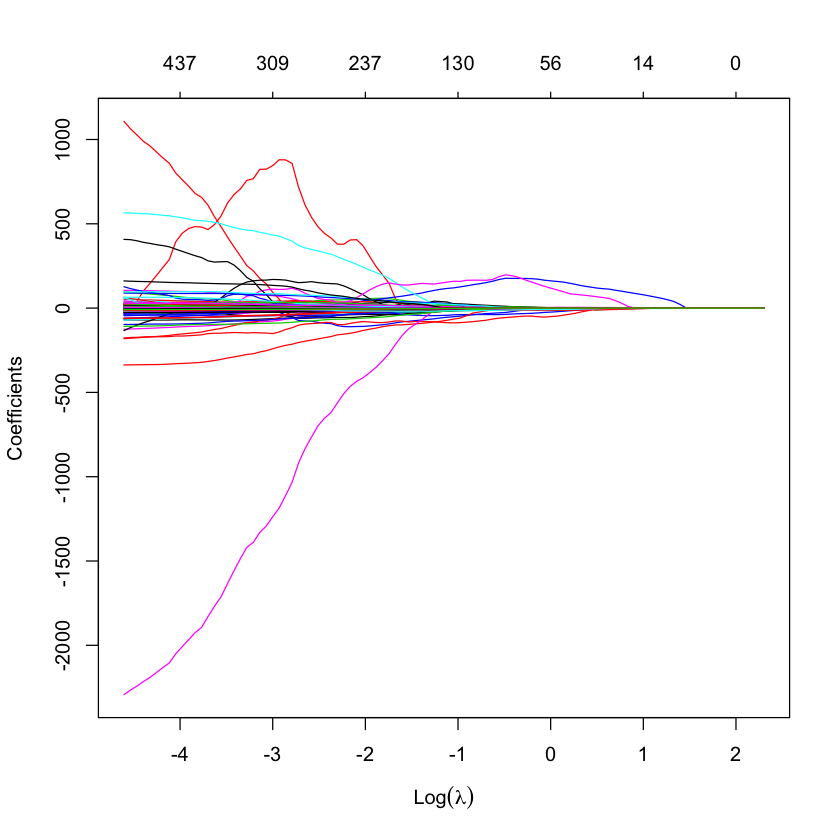

In [10]:
#Lasso regularization 
library(glmnet)
V.data.y = as.matrix(V.data.y)
V.data.x = as.matrix(V.data.x)
lasso.mod <- glmnet(V.data.x,V.data.y, alpha = 1, lambda = 10^seq(1, -2, length = 100))
plot(lasso.mod, "lambda", xlab = parse(text = "Log(lambda)"))

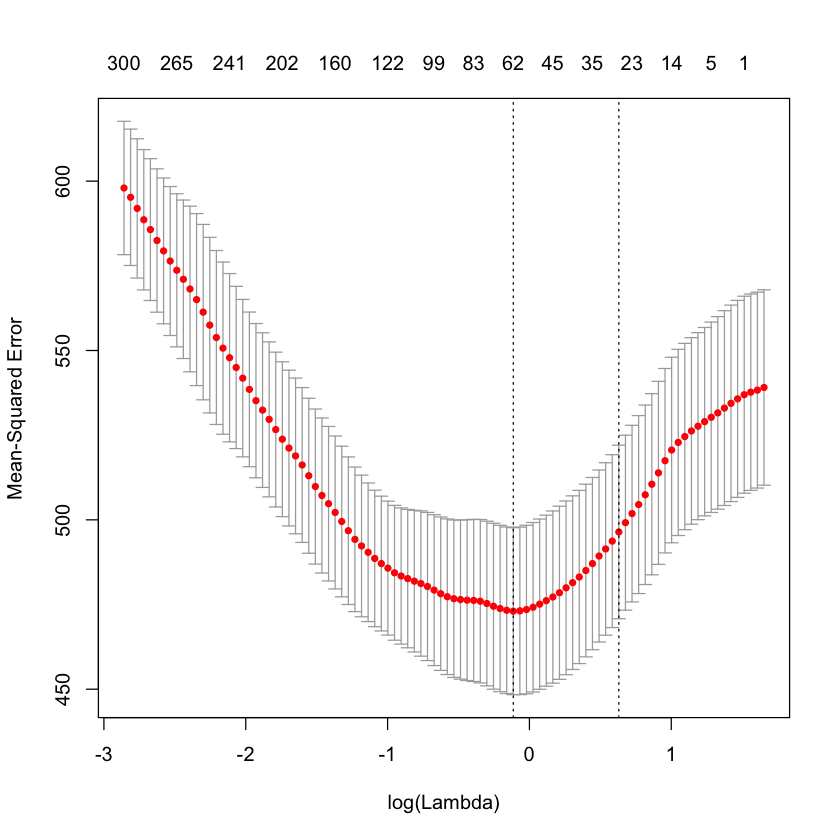

In [11]:
cv.lasso <- cv.glmnet(V.data.x, V.data.y, alpha = 1, nfold = 5)
plot(cv.lasso)

In [12]:
best.lasso <- glmnet(V.data.x, V.data.y, alpha = 1, lambda = cv.lasso$lambda.min)
myCoefs = coef(best.lasso)
NonZeroCoeffs = myCoefs[which(myCoefs != 0 )]
CoeffNames = myCoefs@Dimnames[[1]][which(myCoefs != 0 ) ]
myResults <- data.frame(
  features = myCoefs@Dimnames[[1]][ which(myCoefs != 0 ) ], #intercept included
  coefs    = myCoefs              [ which(myCoefs != 0 ) ]  #intercept included
)
dim(myResults)
myResults


[1] 66  2

features,coefs
(Intercept),38.96818954
D.Dtr05,-0.02786648
SM5_X,-0.03067575
VE2_Dz.p.,-2.26861434
MATS5m,2.69040643
MATS8p,2.62153942
MATS6i,3.36820348
MATS7i,-1.92387513
JGI6,170.05772366
P_VSA_LogP_5,0.09980939
